# Forecasting Methods ETS (Error, Trend, Seasonality) & STLF (Seasonal and Trend decomposition using Loess and Fourier) 

In [22]:
# Carregar Bibliotecas
library(dplyr)
library(xts)
library(ggplot2)
library(forecast)
library(tidyverse)

In [2]:
path <- "C:/Users/Egomes/Desktop/PG_Analytics_Data_science_empresarial/Isla_gaia/14-ProjetoII/projetoII/dataStaging/forecastRevenue.csv"
df <- read.csv(path)
rm(path)
head(df)
str(df)
dim(df)

,store_id,date,summed_revenue
,<chr>,<chr>,<dbl>
1,S0002,2017-01-02,171.59
2,S0002,2017-01-03,178.10
3,S0002,2017-01-04,303.89
4,S0002,2017-01-05,274.65
5,S0002,2017-01-06,193.81
6,S0002,2017-01-07,384.72


'data.frame':	57651 obs. of  3 variables:
 $ store_id      : chr  "S0002" "S0002" "S0002" "S0002" ...
 $ date          : chr  "2017-01-02" "2017-01-03" "2017-01-04" "2017-01-05" ...
 $ summed_revenue: num  172 178 304 275 194 ...


[1] 57651     3

In [3]:
# Alterar tipo da coluna date
df$date <- as.Date(df$date)
str(df)

'data.frame':	57651 obs. of  3 variables:
 $ store_id      : chr  "S0002" "S0002" "S0002" "S0002" ...
 $ date          : Date, format: "2017-01-02" "2017-01-03" ...
 $ summed_revenue: num  172 178 304 275 194 ...


In [4]:
# Criar listas de dataframes com dados de cada store

# criar variável com lista das lojas unicas
stores <- unique(df$store_id)
# Lista para armazenar os dataframes
df_list <- list()
# Loop para criar os dataframes separados
for (store in stores) {
  # filtrar dataframe
  df_store <- df[df$store_id == store,]
  # Adicionar dataframe à lista
  df_list[[store]] <- df_store
}
# ver numero de dataframe criados
length(df_list)

[1] 63

In [5]:
# Converter os dataframes em object xts time series semanais

# lista para armazenar os timeseries
xts_list <- list()
# Loop para criar as séries temporais semanais e armazenar numa lista
for (df_name in names(df_list)) {
  df <- df_list[[df_name]]
  daily <- as.xts(df$summed_revenue, order.by = as.Date(df$date))
  weekly <- apply.weekly(daily, sum)
  xts_list[[df_name]] <- weekly
}
length(xts_list)

[1] 63

In [6]:
# Retirar o último registo de cada dataframe uma vez que não tem 7 dia completos

# Função para remover o último registro de um dataframe
remove_ultimo_registro <- function(df) {
  df <- df[1:(nrow(df)-1), ]
  return(df)
}
# Remover o último registro de cada dataframe da lista
xts_list <- lapply(xts_list, remove_ultimo_registro)

In [7]:
# Criar nova lista de dataframes com granularidade semanal

df_list_week <- list()

#loop
for( xts_name in names(xts_list)){
    df <- xts_list[[xts_name]]
    df <- data.frame(date = index(df), revenue = df)
    df_list_week[[xts_name]] <- df
}
length(df_list_week)

[1] 63

In [8]:
# Dividir dados treino e teste

# Lista para armazenar os timeseries teste e treino
df_train <- list()
df_test <- list()

# Loop para criar as séries temporais semanais e armazenar nas lista
for (t in names(df_list_week)) {
  data <- df_list_week[[t]]
  train <- head(data, -5)
  test <- tail(data, 5)
  df_train[[t]] <- train
  df_test[[t]] <- test
}
length(df_train)
length(df_test)

[1] 63

[1] 63

In [9]:
# Converter em timeseries ts

# lista para armazenar os timeseries 
ts_real <- list()
ts_train <- list()
ts_test <- list()
# Loop
for(t in names(df_list_week)){
    data <- df_list_week[[t]]
    ts <- ts(data = data$revenue, frequency = 52)
    ts_real[[t]] <- ts
}

# Loop
for(t in names(df_train)){
    data <- df_train[[t]]
    ts <- ts(data = data$revenue, frequency = 52)
    ts_train[[t]] <- ts
}
# Loop
for(t in names(df_test)){
    data <- df_test[[t]]
    ts <- ts(data = data$revenue, frequency = 52)
    ts_test[[t]] <- ts
}
length(ts_train)
length(ts_test)
length(ts_real)

[1] 63

[1] 63

[1] 63

## Model ETS (Error, Trend, Seasonality) 

In [10]:
# Model ETS (Error, Trend, Seasonality) 

# Armazenar previsões ets model 
ets_prev <- list()

# Loop
for (ts in names(ts_train)){
    data <- ts_train[[ts]]
    data <- tail(data, 24)
    model_ets <- forecast(ets(data), h = 5)
    ets_prev[[ts]] <- model_ets$mean
}
length(ets_prev)

[1] 63

In [11]:
# Resumo modelo ex: loja S0143
summary(model_ets)


Forecast method: ETS(M,N,N)

Model Information:
ETS(M,N,N) 

Call:
 ets(y = data) 

  Smoothing parameters:
    alpha = 0.8138 

  Initial states:
    l = 407.8041 

  sigma:  0.2828

     AIC     AICc      BIC 
312.1370 313.3370 315.6711 

Error measures:
                   ME     RMSE     MAE      MPE     MAPE MASE      ACF1
Training set 34.07957 139.4948 98.2703 1.725692 18.89962  NaN 0.0810585

Forecasts:
         Point Forecast    Lo 80    Hi 80       Lo 95    Hi 95
3.653846        1073.43 684.3320 1462.527  478.356137 1668.503
3.673077        1073.43 563.8341 1583.025  294.070475 1852.789
3.692308        1073.43 462.1065 1684.753  138.491540 2008.368
3.711538        1073.43 370.7305 1776.129   -1.255972 2148.115
3.730769        1073.43 285.8904 1860.969 -131.007653 2277.867


	Ljung-Box test

data:  Residuals from ETS(M,N,N)
Q* = 0.27285, df = 5, p-value = 0.9981

Model df: 0.   Total lags used: 5



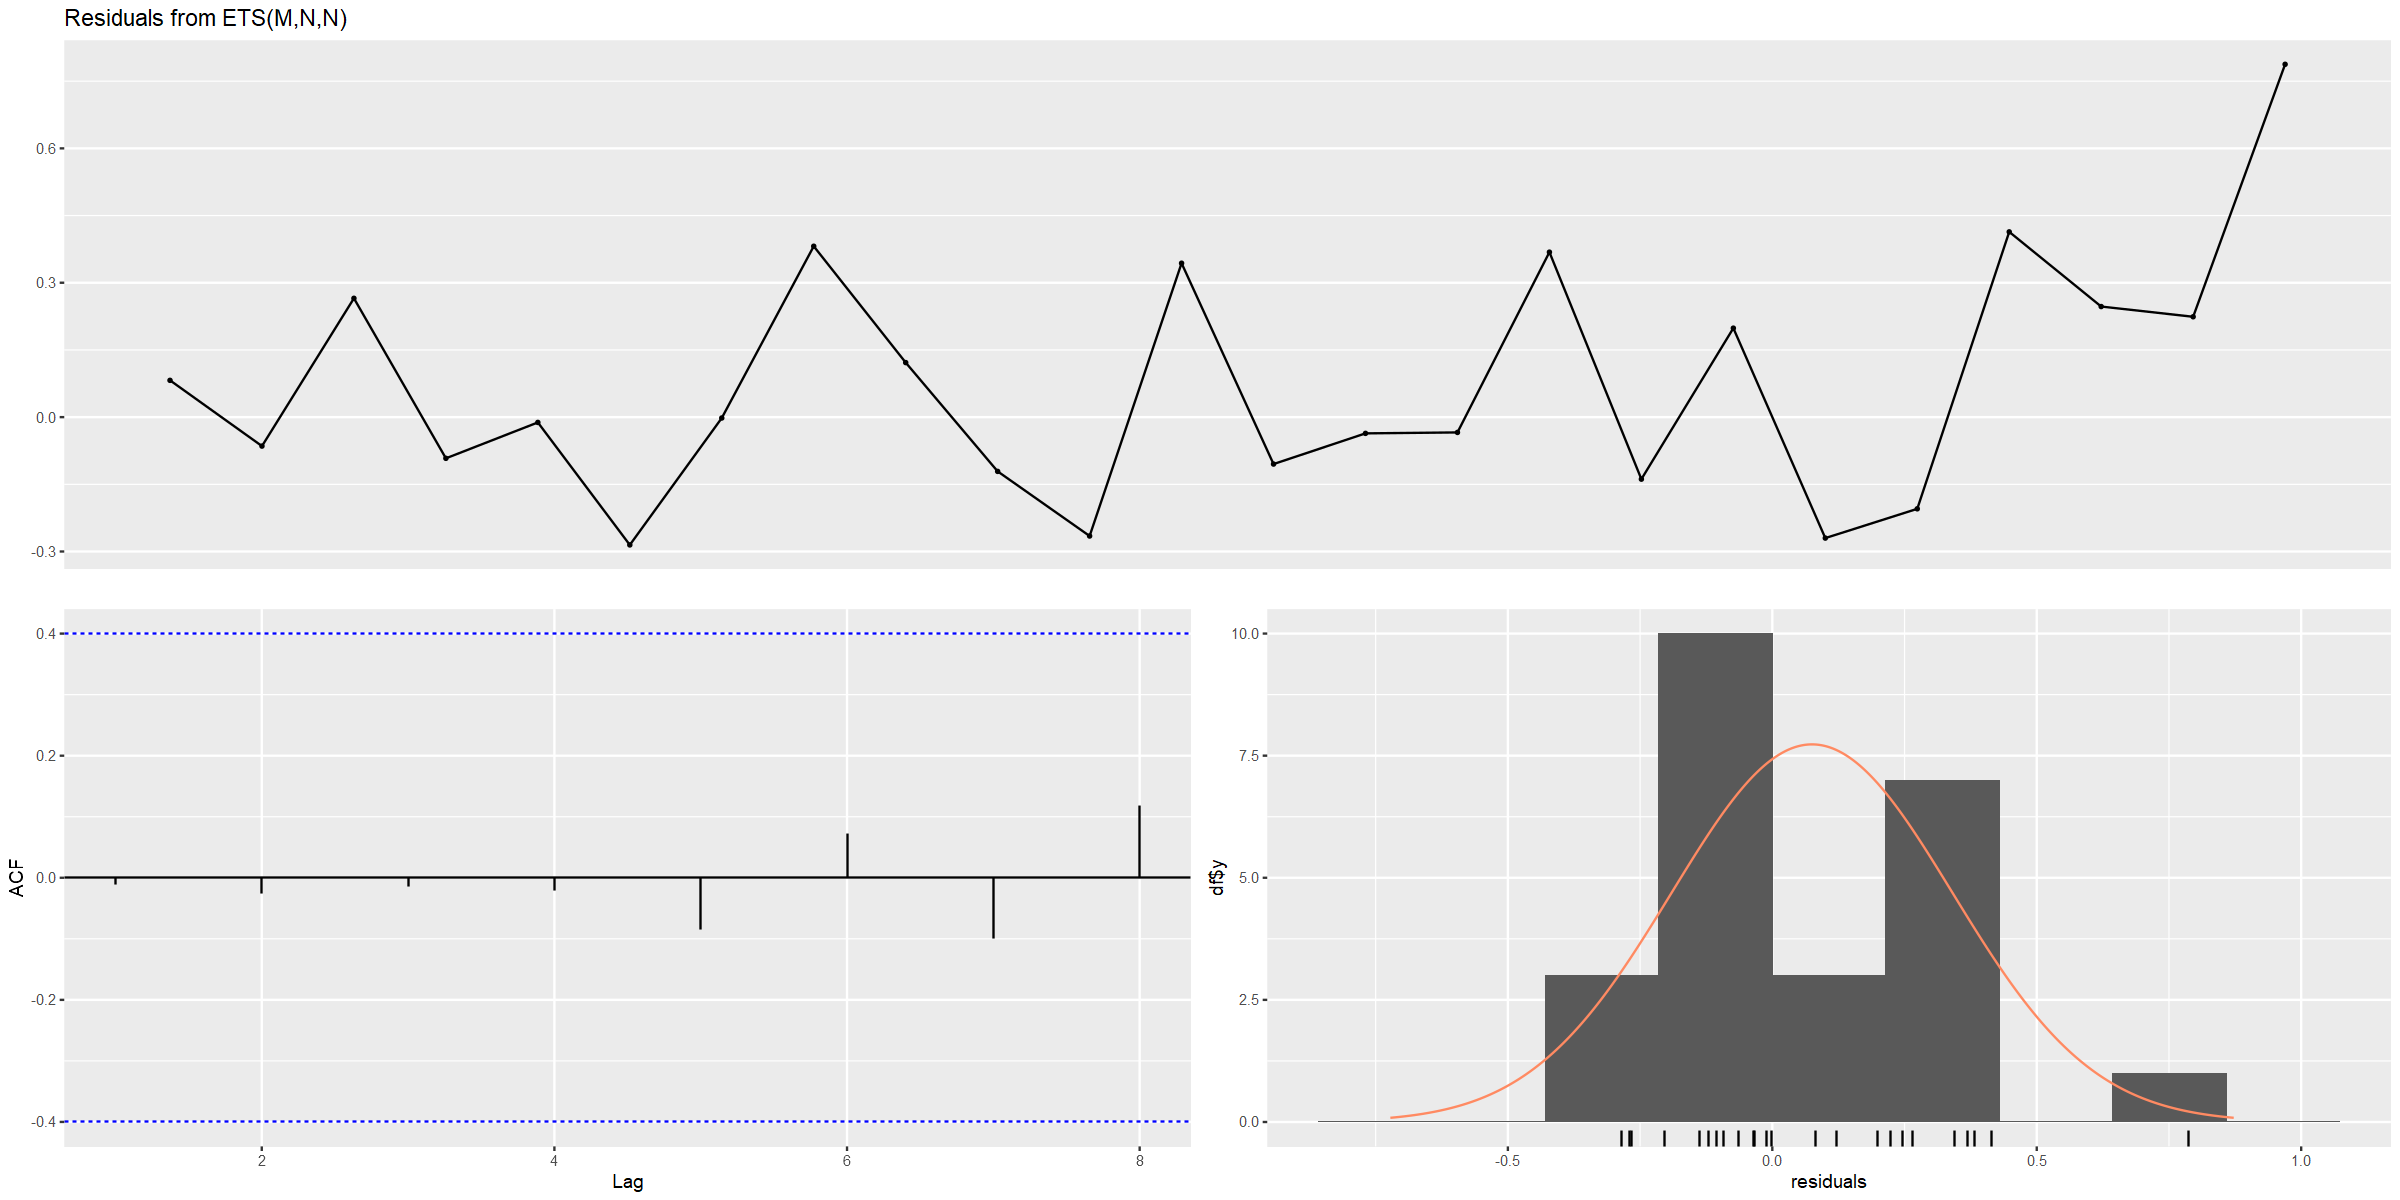

In [12]:
# Ver resuiduos ex: loja S0143
options(repr.plot.width = 20, repr.plot.height = 10)
checkresiduals(model_ets)

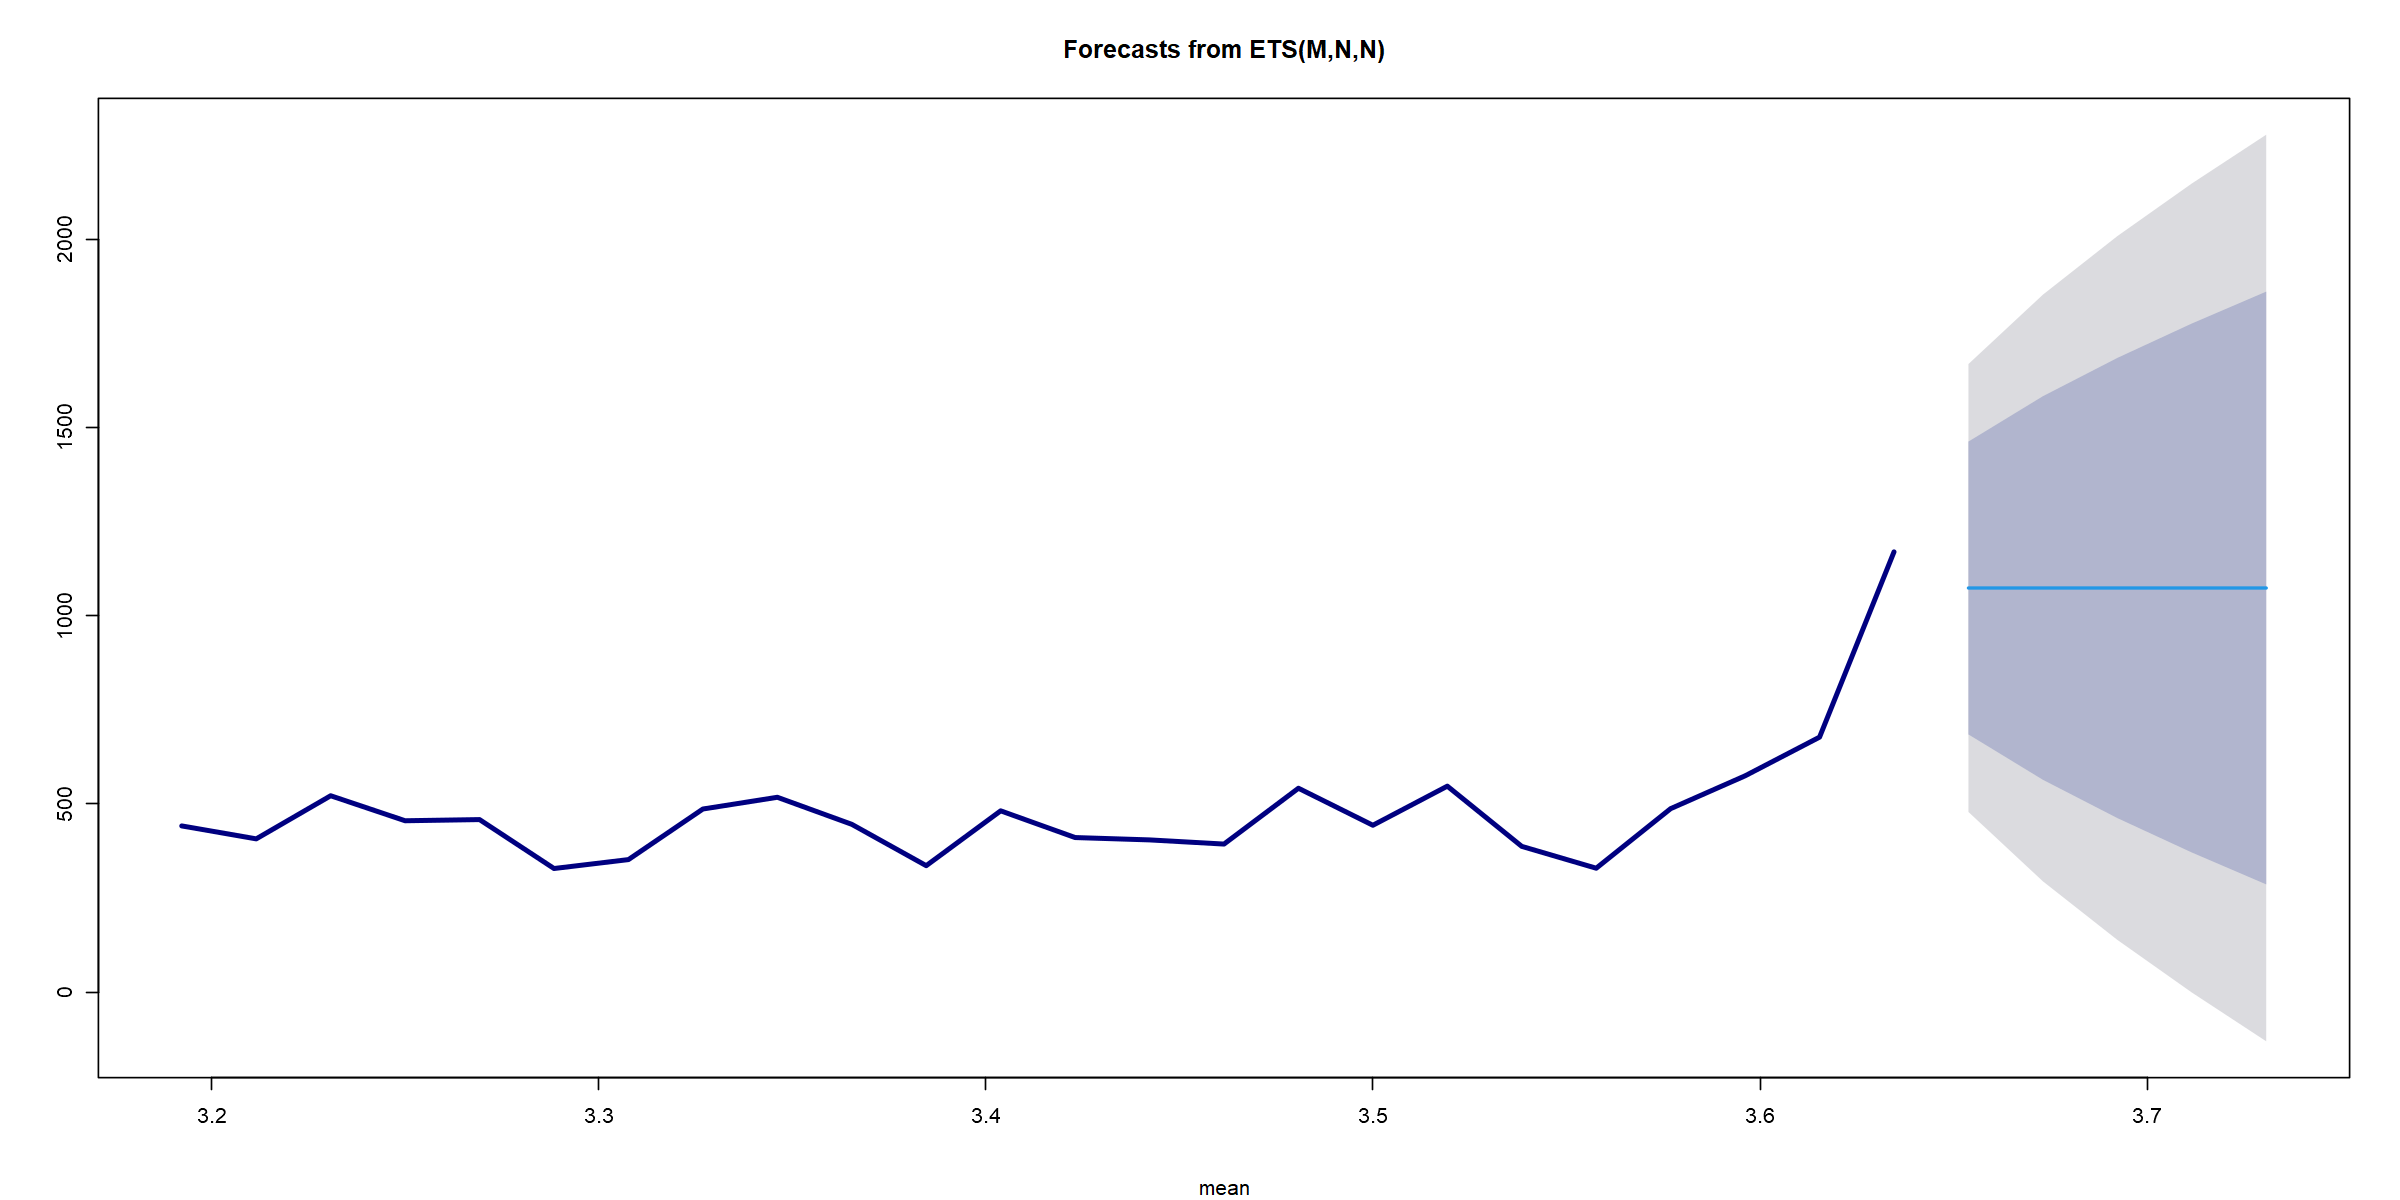

In [13]:
# Ver previsões ex: loja S0143
options(repr.plot.width = 20, repr.plot.height = 10)
predict_ets_model <- model_ets
plot(predict_ets_model,
     sub = "mean",
     col = "navyblue",
     lwd = 3)

## Model STLF (Seasonal and Trend decomposition using Loess and Fourier) 

In [14]:
# Model STLF (Seasonal and Trend decomposition using Loess and Fourier) 
# O modelo STLF é particularmente útil para dados com tendência e sazonalidade, pois é capaz de capturar tanto os padrões sazonais quanto a tendência de longo prazo.

# Armazenar previsões stlf model 
stlf_prev <- list()

# Loop
for (ts in names(ts_train)){
  if (ts %in% c("S0005", "S0007", "S0036", "S0046","S0061","S0071", "S0076", "S0092","S0109","S0136")) {
    # series que não têm 2 periodos completos
    stlf_prev[[ts]] <- rep(NA, 5)
  } else {
    data <- ts_train[[ts]]
    model_stlf <- stlf(data,5)
    stlf_prev[[ts]] <- model_stlf$mean
  }
}
length(stlf_prev)


[1] 63

Este modelo tem em conta pelo menos 2 periodos anteriores para avaliar tendência e sazonalidade, por este fato exitem lojam sem previsão de valores uma vez que não existe 2 periodos de histórico. 

In [15]:
# Resumo modelo ex: loja S0143
summary(model_stlf)


Forecast method: STL +  ETS(M,A,N)

Model Information:
ETS(M,A,N) 

Call:
 ets(y = na.interp(x), model = etsmodel, allow.multiplicative.trend = allow.multiplicative.trend) 

  Smoothing parameters:
    alpha = 0.013 
    beta  = 0.013 

  Initial states:
    l = 327.4406 
    b = -4.3076 

  sigma:  0.2403

     AIC     AICc      BIC 
1911.837 1912.291 1926.473 

Error measures:
                   ME     RMSE      MAE       MPE     MAPE      MASE      ACF1
Training set 8.972574 88.71027 60.26973 -1.030193 16.51766 0.4425173 0.1592575

Forecasts:
         Point Forecast    Lo 80     Hi 80    Lo 95     Hi 95
3.653846       547.0500 377.8853  716.2146 288.3349  805.7650
3.673077       593.7861 420.9418  766.6304 329.4436  858.1286
3.692308       864.2095 687.6134 1040.8056 594.1291 1134.2900
3.711538       565.9789 385.5318  746.4259 290.0090  841.9487
3.730769       561.4158 376.9931  745.8385 279.3657  843.4660


	Ljung-Box test

data:  Residuals from STL +  ETS(M,A,N)
Q* = 47.115, df = 28, p-value = 0.01332

Model df: 0.   Total lags used: 28



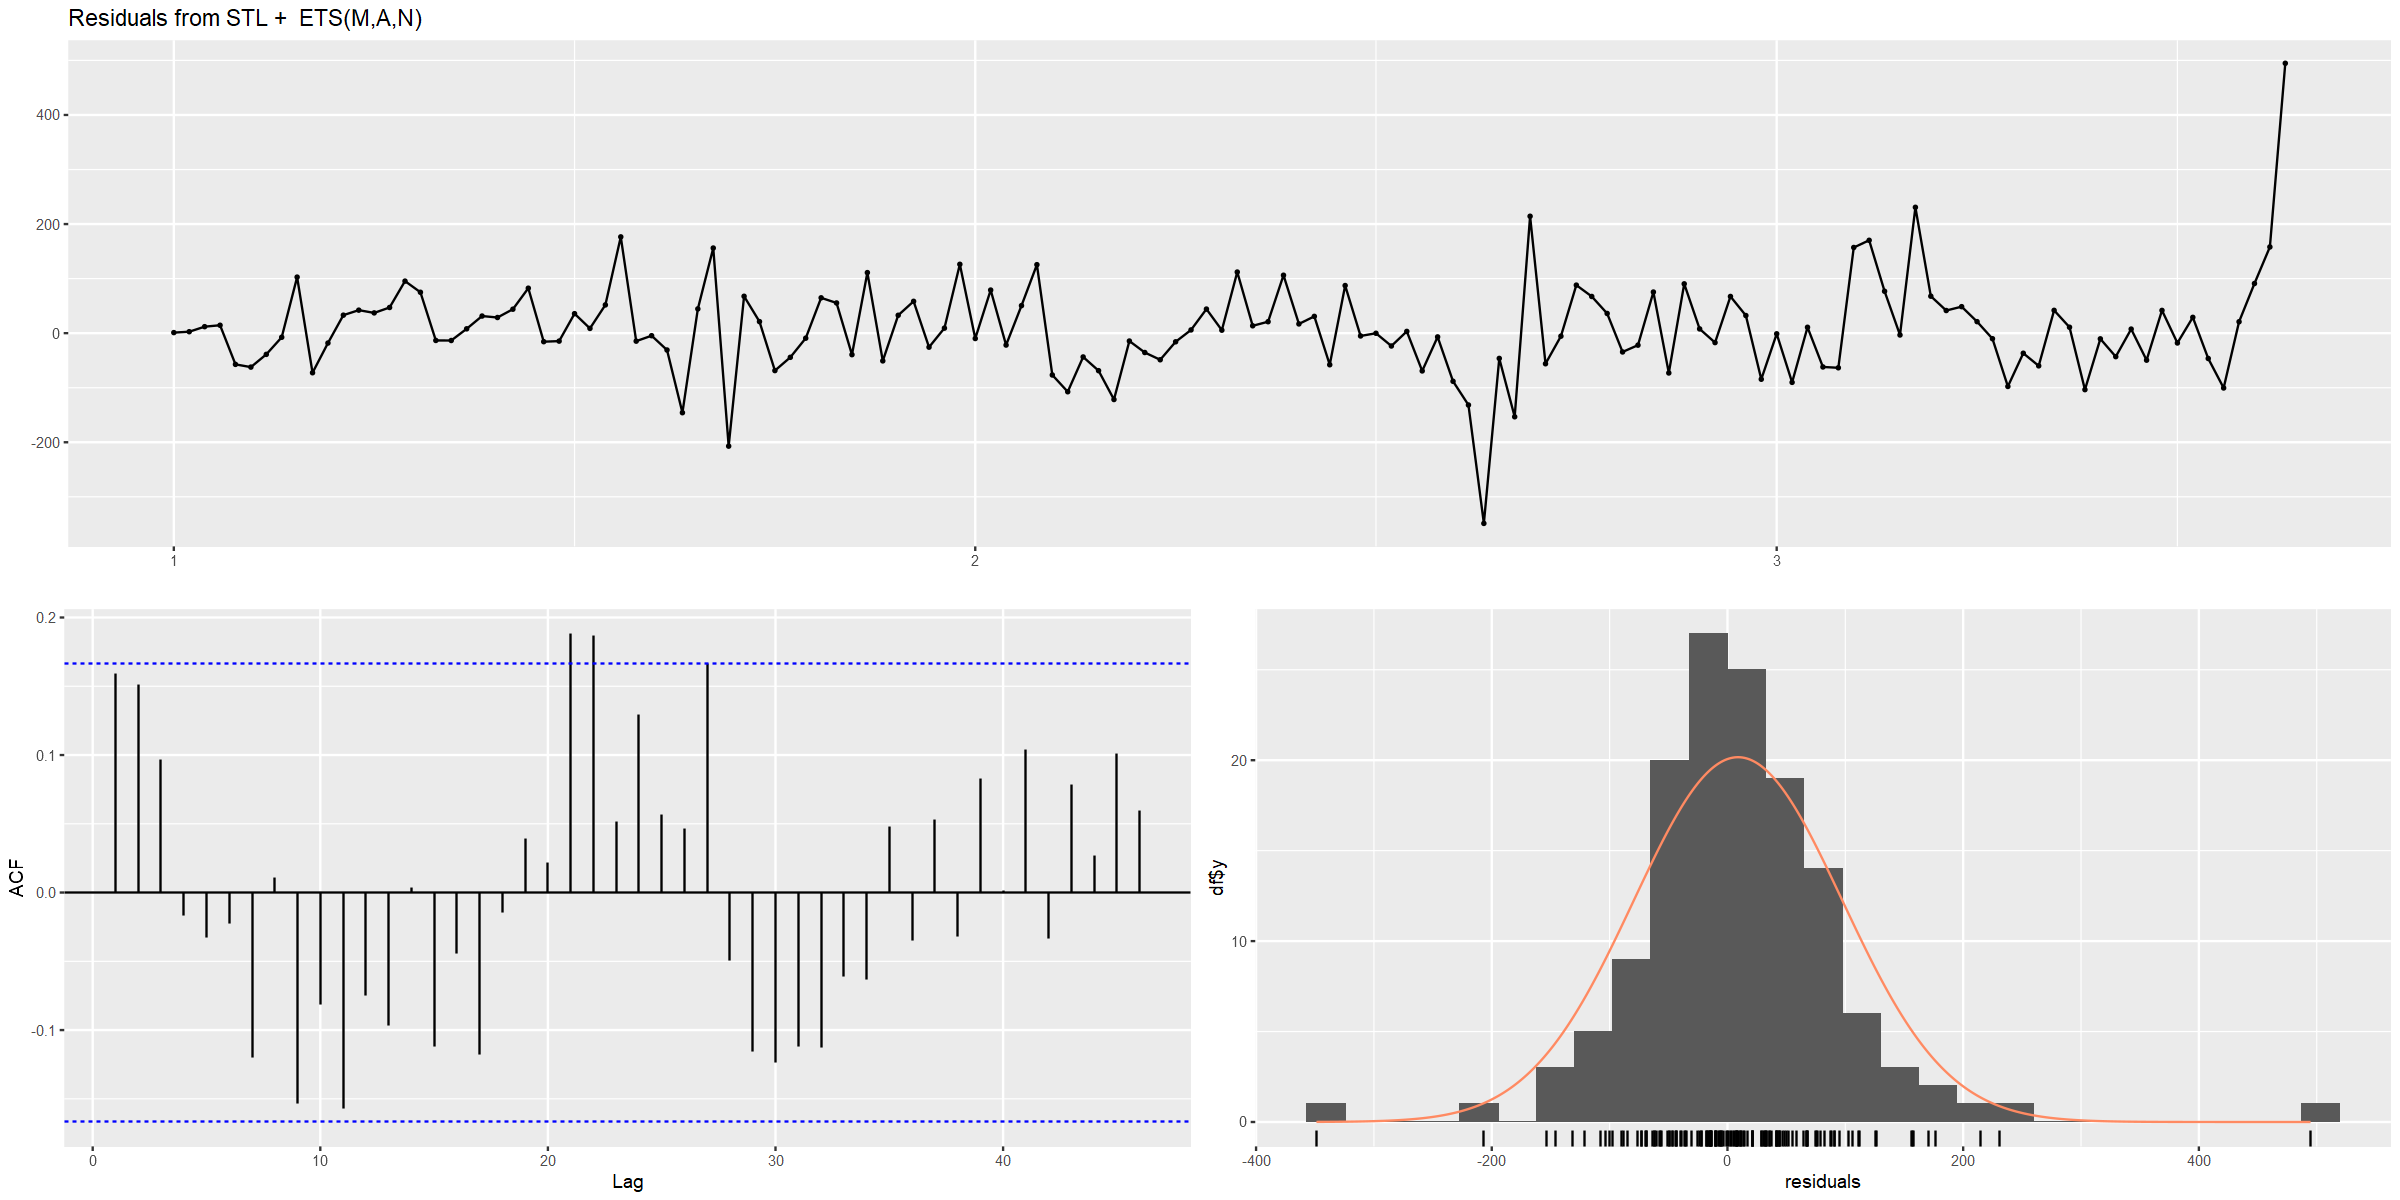

In [16]:
# Ver resuiduos ex: loja S0143
options(repr.plot.width = 20, repr.plot.height = 10)
checkresiduals(model_stlf)

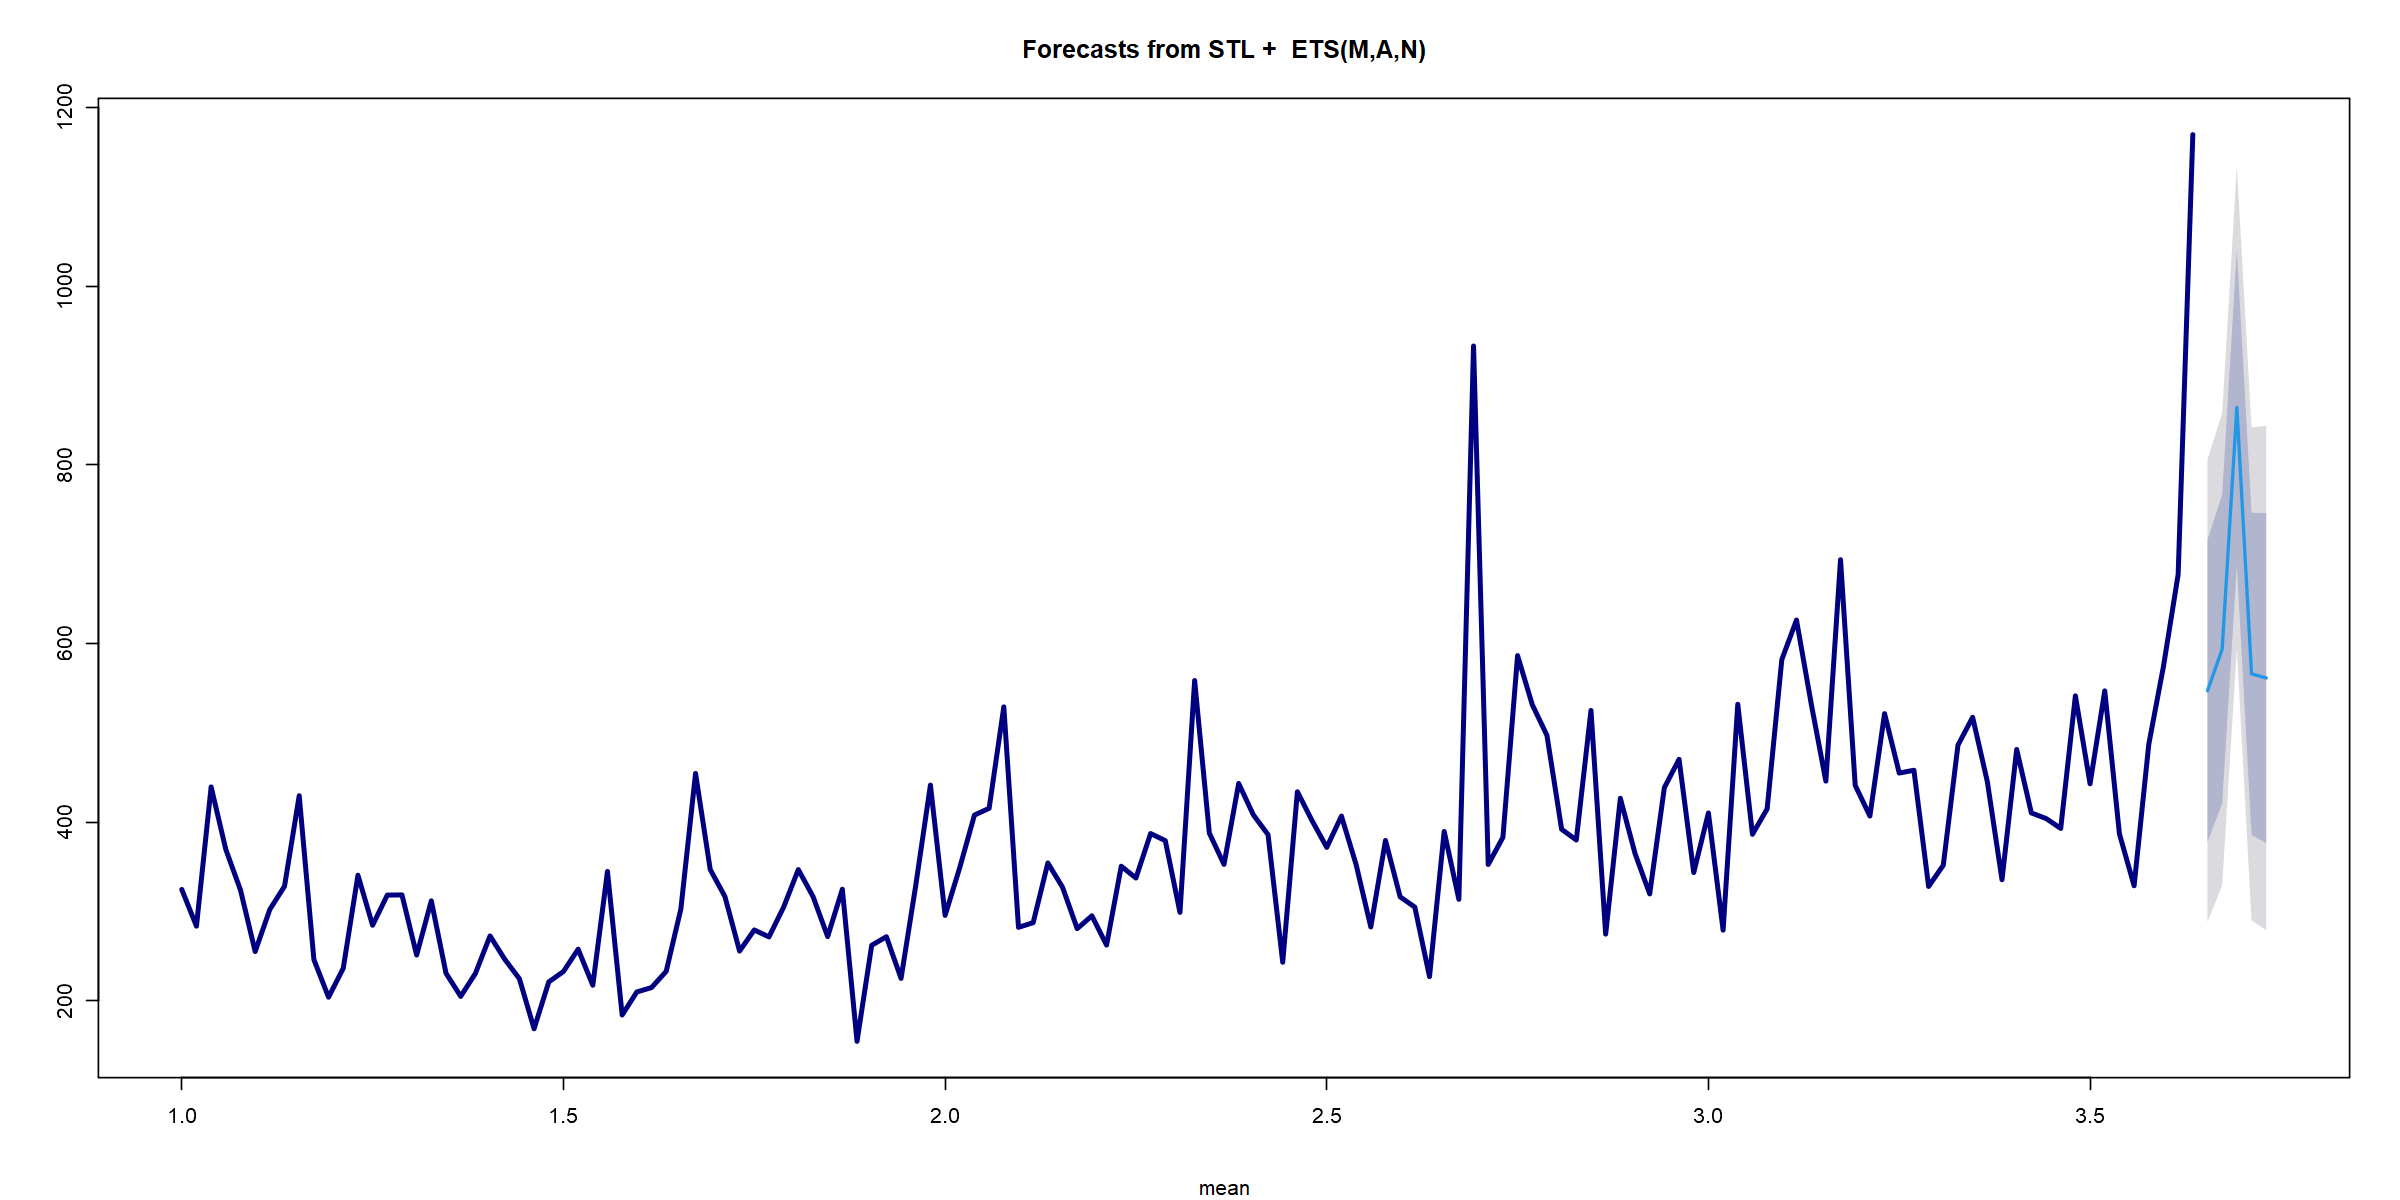

In [17]:
# Ver previsões ex: loja S0143
options(repr.plot.width = 20, repr.plot.height = 10)
predict_stlf_model <- model_stlf
plot(predict_stlf_model,
     sub = "mean",
     col = "navyblue",
     lwd = 3)

## Evaluation Dataframe

In [18]:
# Criar dataframe com resultados reais
prev <- do.call(rbind, df_test)

# Inserir o nome dos dataframes como uma coluna chamada "store_id"
prev$store_id <- rep(names(df_test), sapply(df_test, nrow))

# criar dataframe com os resultados ets
result <- do.call(rbind, ets_prev)
store_id <-names(ets_prev)
# Combinação do índice com a matriz
result_ets <- data.frame(store_id = store_id, result)
result_ets <- result_ets %>% pivot_longer(cols = -store_id, names_to = "prev", values_to = "ets_revenue")

# criar dataframe com os resultados lm
result <- do.call(rbind, stlf_prev)
store_id <-names(stlf_prev)
# Combinação do índice com a matriz
result_stlf <- data.frame(store_id = store_id, result)
result_stlf <- result_stlf %>% pivot_longer(cols = -store_id, names_to = "prev", values_to = "stlf_revenue")

# Juntar resultados no dataframe prev
prev$ets_revenue <- result_ets$ets_revenue
prev$stlf_revenue <- result_stlf$stlf_revenue

# Ver 20 linhas aleatórias
prev %>% sample_n(20)


,date,revenue,store_id,ets_revenue,stlf_revenue
,<date>,<dbl>,<chr>,<dbl>,<dbl>
S0097.2019-09-22,2019-09-22,7858.83,S0097,20042.1960,9309.3269
S0120.2019-09-08,2019-09-08,404.31,S0120,416.8874,439.0641
S0016.2019-09-08,2019-09-08,698.55,S0016,730.4148,832.7279
S0002.2019-09-22,2019-09-22,3074.56,S0002,16282.6146,6896.4146
S0062.2019-09-08,2019-09-08,10623.03,S0062,30983.0172,13762.2357
S0026.2019-09-15,2019-09-15,12547.99,S0026,37183.5611,27162.9214
S0023.2019-09-08,2019-09-08,4100.42,S0023,10980.5234,4048.0773
S0016.2019-09-01,2019-09-01,587.25,S0016,730.4148,722.5710
S0052.2019-09-22,2019-09-22,1383.06,S0052,3269.3725,1557.5352


## Visualização de previsões e dados reais

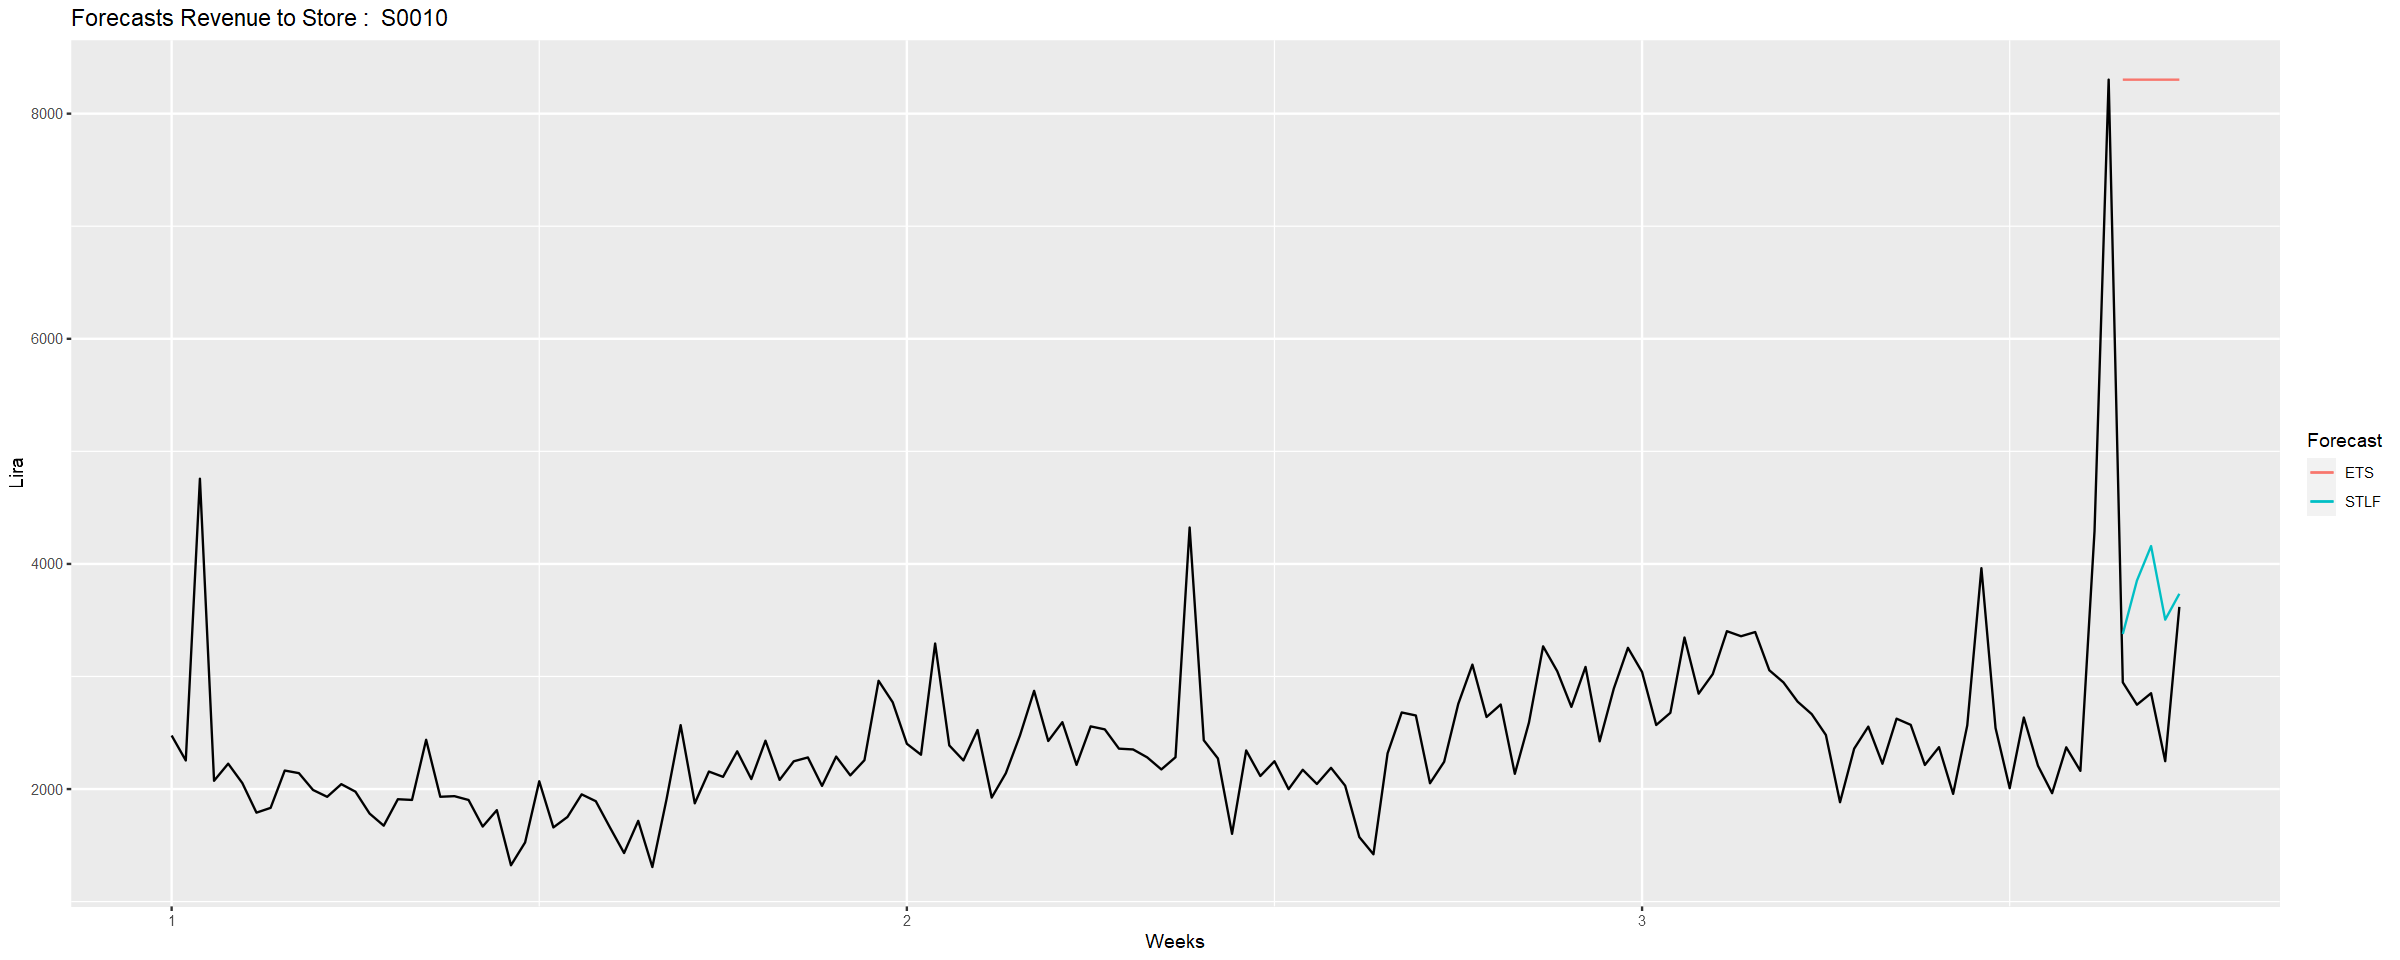

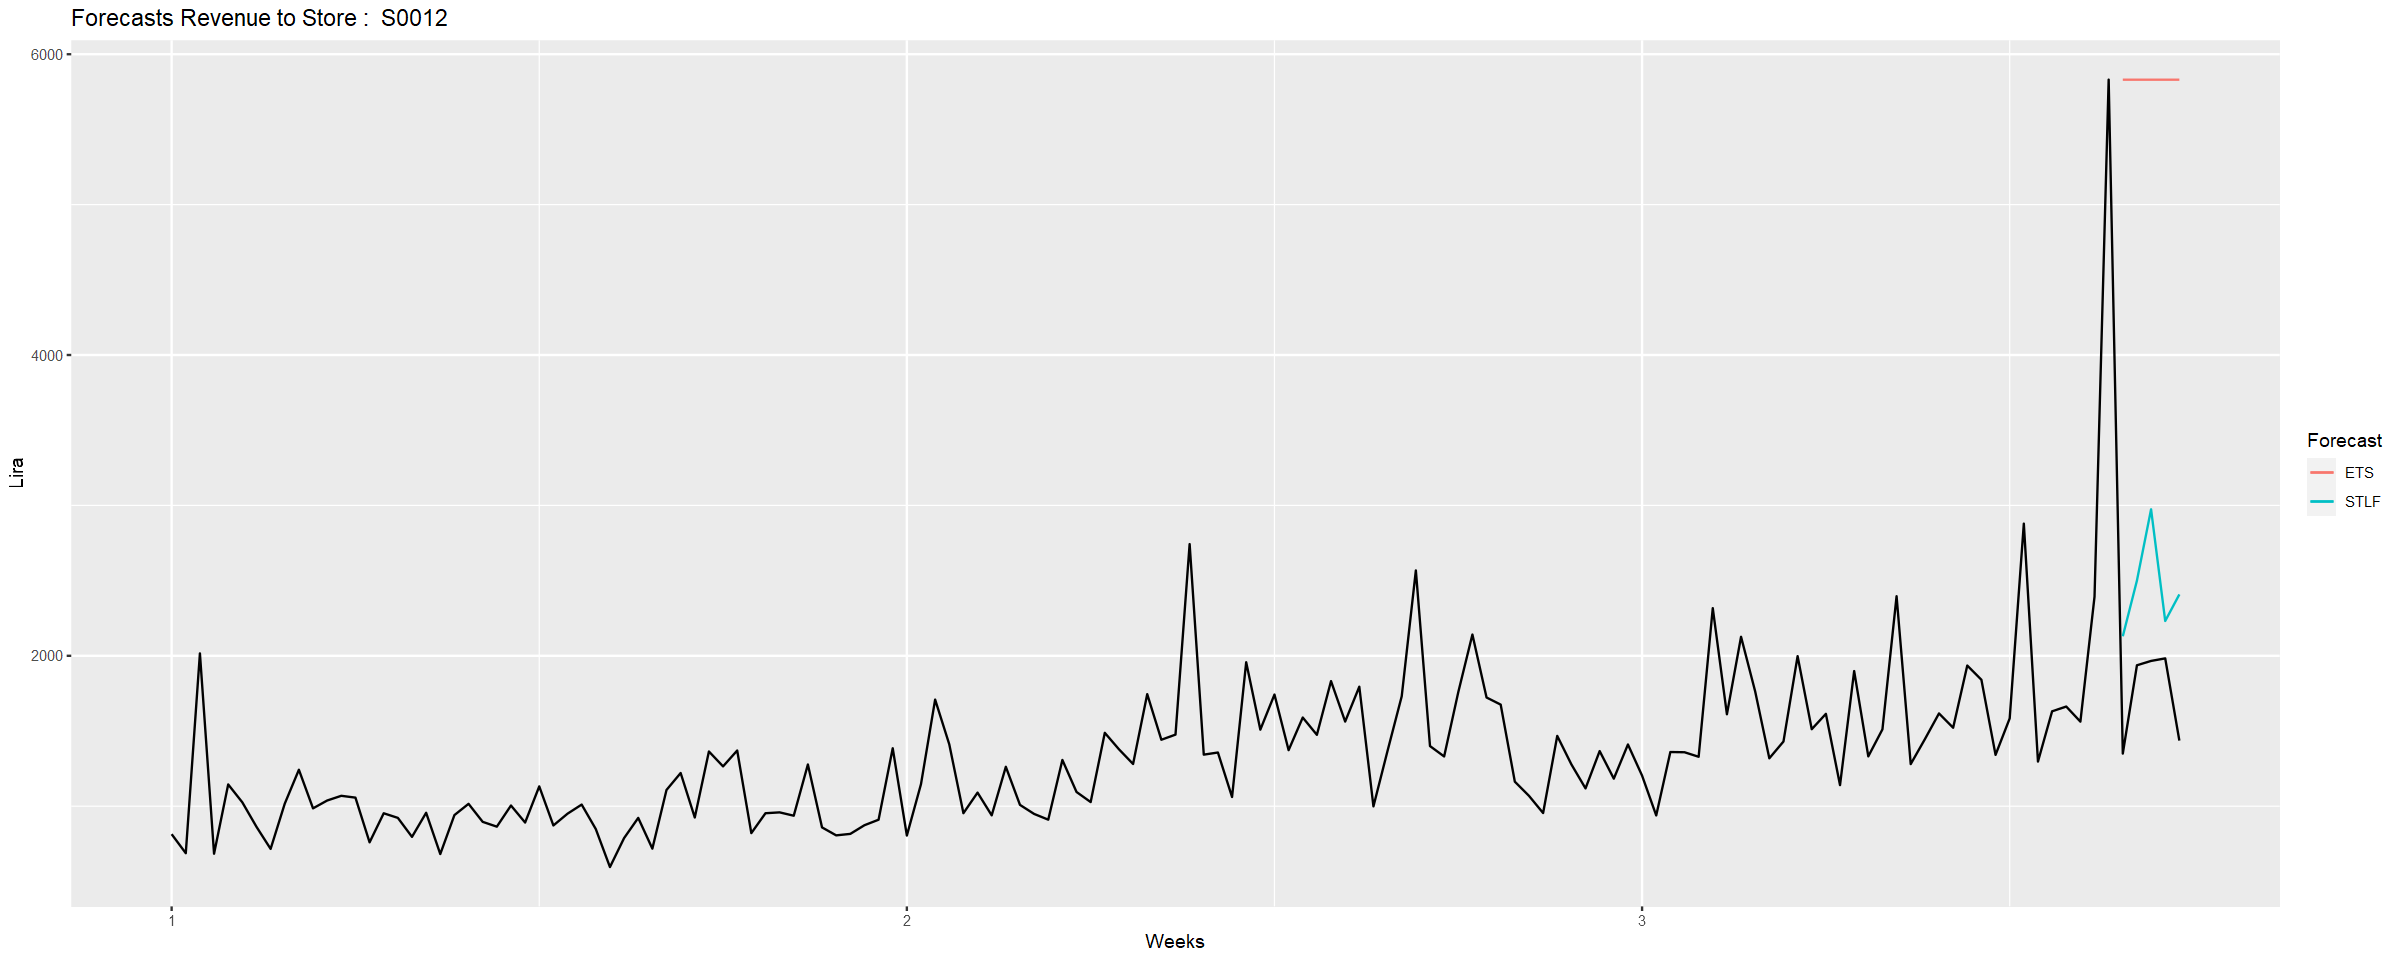

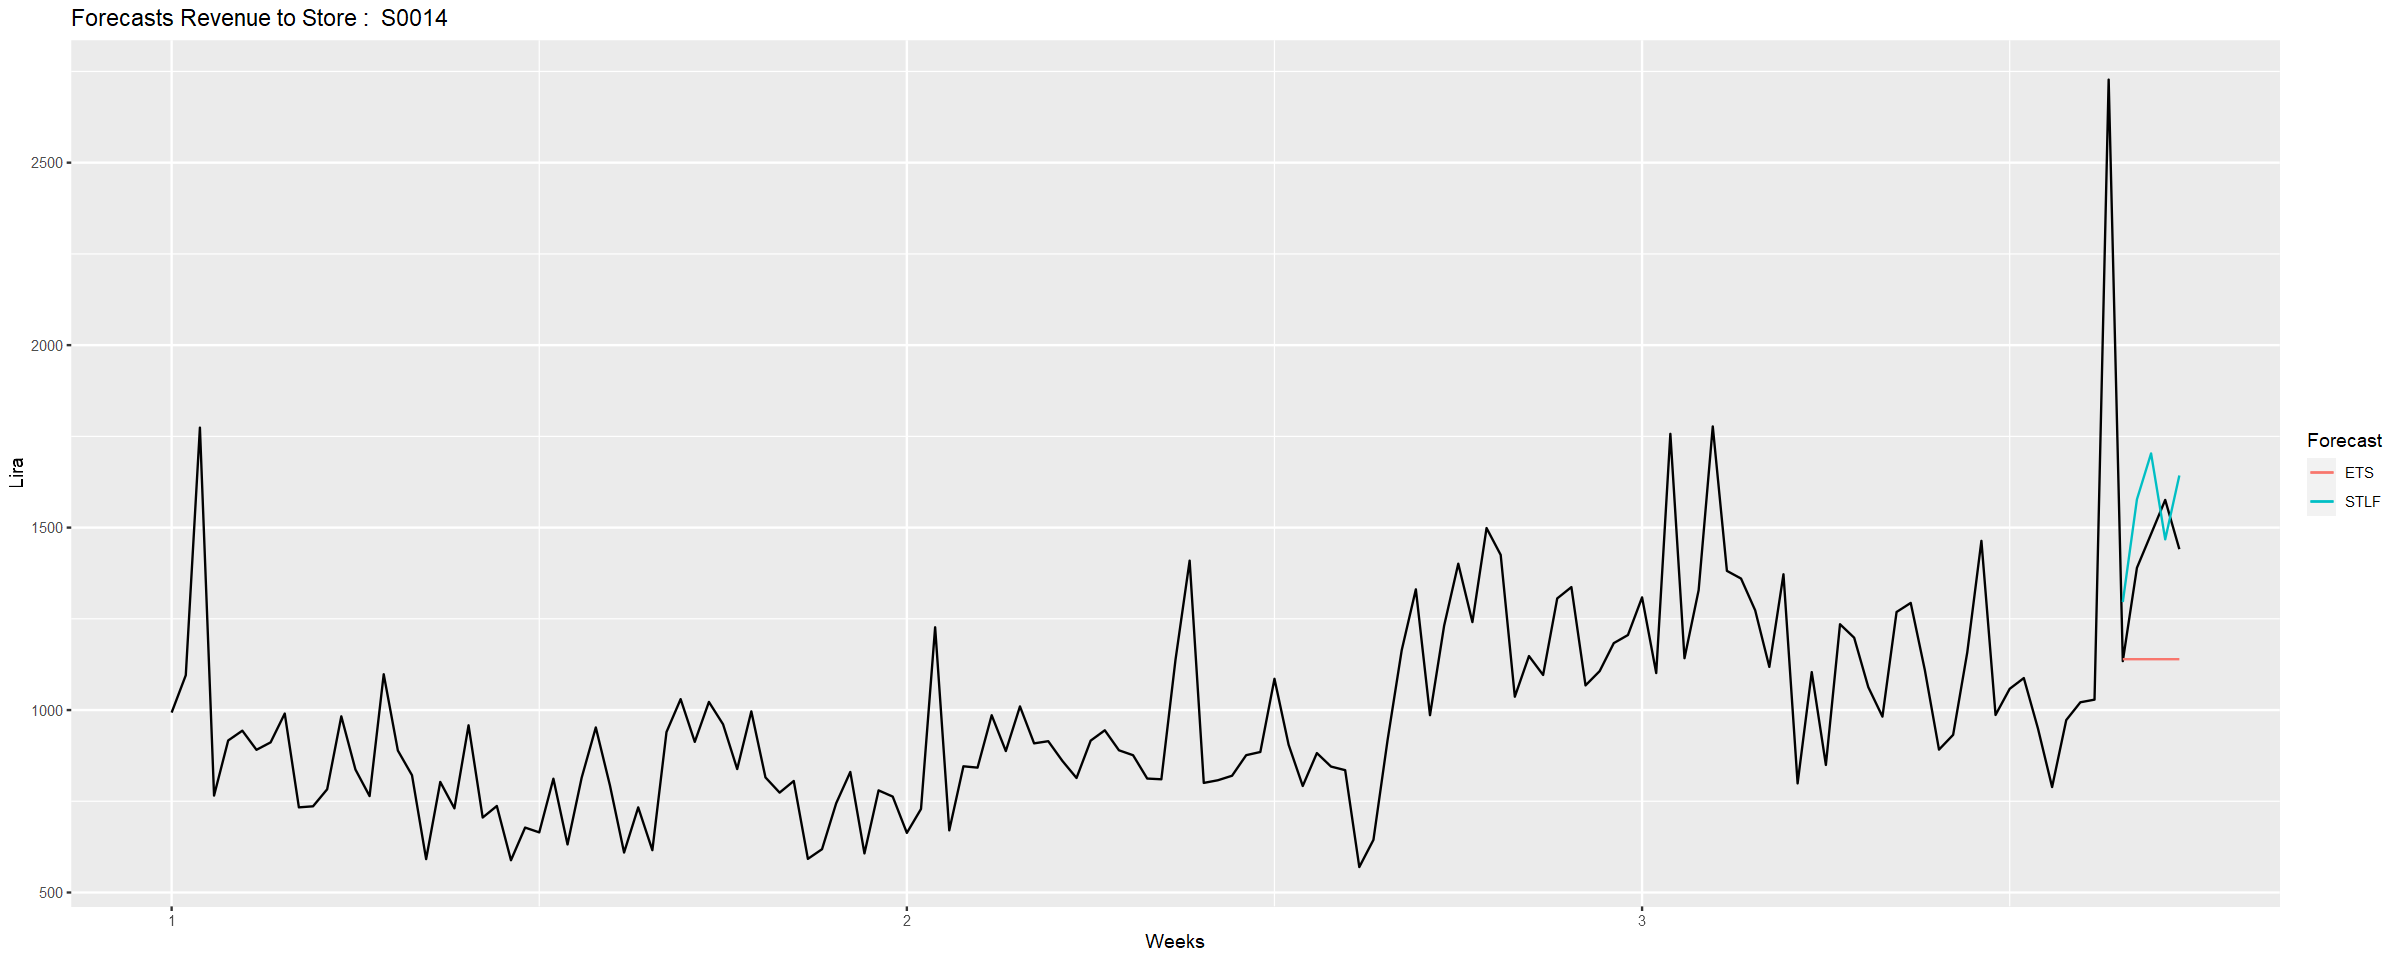

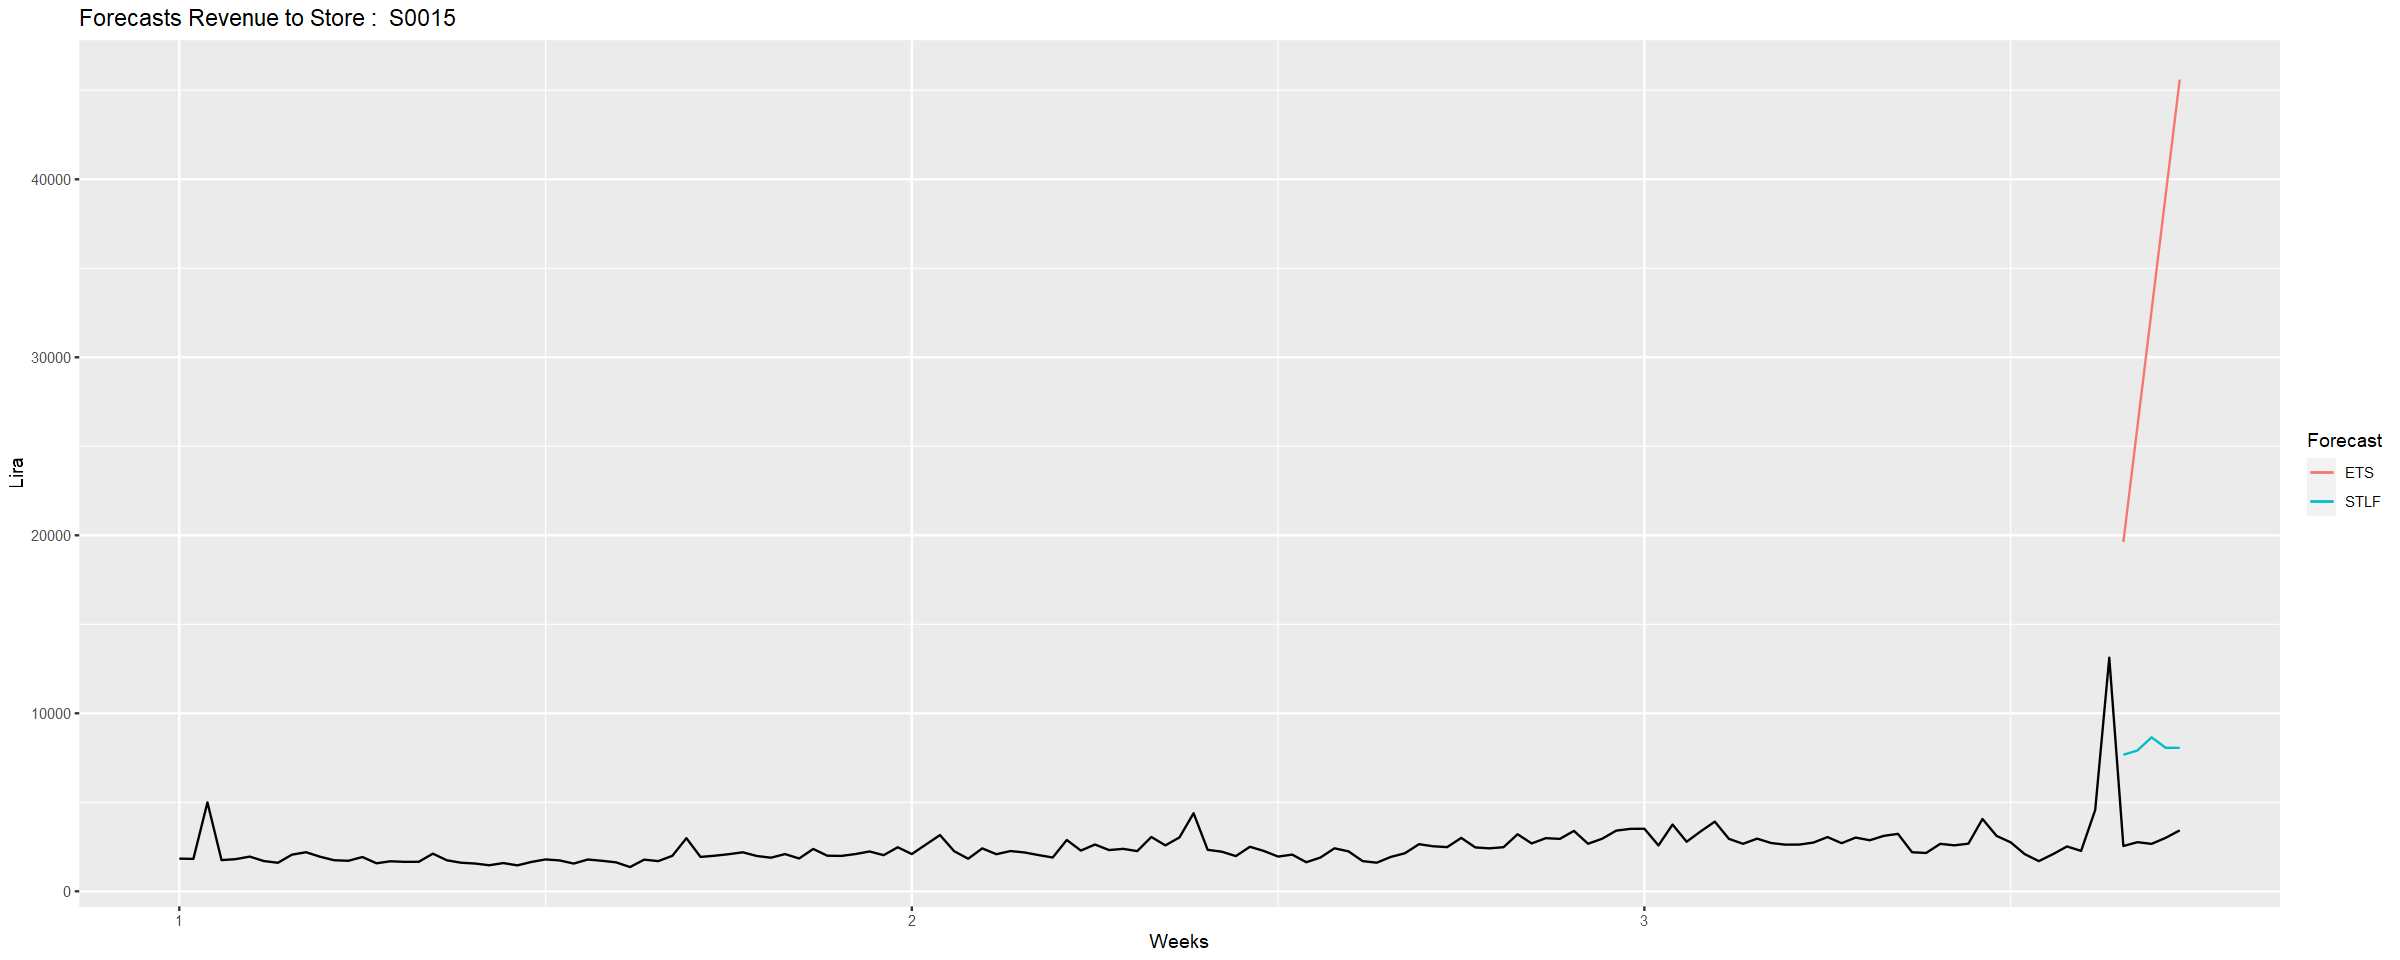

In [19]:
# Ver graficamente as previsões para 3 lojas
options(repr.plot.width = 20, repr.plot.height = 8)

for (i in 5:length(ts_train)) {
  ts_name <- names(ts_train)[i]
  ts <- ts_train[[ts_name]]
  
  if (i <= 8) {
    plot <- autoplot(ts_real[[i]]) +
    autolayer(ets_prev[[i]], series = "ETS")+
    autolayer(stlf_prev[[i]], series = "STLF")+
    ggtitle(paste("Forecasts Revenue to Store : ",ts_name))+
    xlab("Weeks") + ylab("Lira") +
    guides(colour=guide_legend(title="Forecast"))
      
    print(plot)
  }
}

## Evaluation test data


In [20]:
# Como exemplo selecionar loja S0012
S0012 <- subset(prev, store_id == "S0012")
# Accuaracy ets models
accuracy(S0012$ets_revenue, S0012$revenue)
# Accuaracy stlf models
accuracy(S0012$stlf_revenue, S0012$revenue)

,ME,RMSE,MAE,MPE,MAPE
Test set,-4096.377,4105.964,4096.377,-245.9288,245.9288


,ME,RMSE,MAE,MPE,MAPE
Test set,-714.3943,767.8882,714.3943,-43.67242,43.67242


Como exemplo de avaliação dos modelos em previsão da revenue para a loja  S0012, podemos verificar que o modelo stlf tem melhor precisão.

In [21]:
# Exportar resultados
path <- file.path("C:", "Users", "Egomes", "Desktop", "PG_Analytics_Data_science_empresarial", "Isla_gaia", "14-ProjetoII", "projetoII", "dataStaging", "resultEtsModels.csv")
write.csv(prev, file = path, row.names = FALSE)
print('Exportação concluida!')

[1] "Exportação concluida!"
